In [1]:
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F

from my_models.style_gan_2 import Generator
from sklearn.linear_model import LogisticRegression
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
import matplotlib.pylab as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [82]:
g = Generator(1024, 512, 8, pretrained=True).eval().to(device)
g.noises = [n.to(device) for n in g.noises]

def generate_image(g, latent_vector):
    with torch.no_grad():
        img, _ = g([latent_vector], input_is_latent=True, noise=g.noises)
        img = make_grid(img.cpu(), normalize=True, range=(-1, 1))
    img = transforms.ToPILImage('RGB')(img)
    img.resize((256, 256))
    return img


def move_and_show(g, latent_vector, direction, coeffs, emotion):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 4), dpi=80)
    fig.suptitle(emotion)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[:8] = (latent_vector + coeff * direction)[:8]
        # new_latent_vector[:8] -= (coeff * direction)[:8].mean(axis=1)
        # new_latent_vector = (latent_vector + coeff * direction)
        new_latent_vector = torch.tensor(new_latent_vector, dtype=torch.float32, device=device).unsqueeze(0)
        img = generate_image(g, new_latent_vector)
        ax[i].imshow(img)
        ax[i].set_title('Coeff: %0.1f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()


def move_and_show_non_lin(g, inn, latent_vector, coeffs, emotion):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 4), dpi=80)
    fig.suptitle(emotion)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        inn.eval()
        direction = inn.inverse(coeff)
        new_latent_vector[:8] = (latent_vector + direction)[:8]
        # new_latent_vector[:8] -= (coeff * direction)[:8].mean(axis=1)
        # new_latent_vector = (latent_vector + coeff * direction)
        new_latent_vector = torch.tensor(new_latent_vector, dtype=torch.float32, device=device).unsqueeze(0)
        img = generate_image(g, new_latent_vector)
        ax[i].imshow(img)
        ax[i].set_title('Coeff: %0.1f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()

torch.Size([20000, 1, 512]) torch.Size([20000, 8]) torch.Size([20000, 8])
[0 1 2 3 4 5 6 7] [ 153 1088 2638 2839 4525 1510 6740  507]


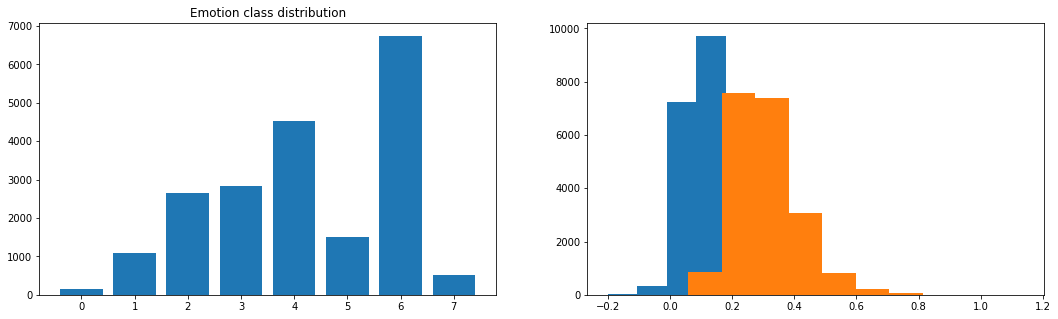

In [36]:
data = torch.load('saves/control_latent/latent_training_data_20000.pt')

latents = data['latents']
scores_rav = data['scores_rav']
scores_fer = data['scores_fer']
valence_arousal = data['valence_arousal']
valence = valence_arousal[:, 0].numpy()
arousal = valence_arousal[:, 1].numpy()
print(latents.shape, scores_rav.shape, scores_fer.shape)

unique, counts = np.unique(torch.max(scores_rav, dim=1)[1].numpy(), return_counts=True)
print(unique, counts)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1.bar(unique, counts)
ax1.set_title("Emotion class distribution")
ax1.set_xticks(np.arange(8), ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgusted', 'surprised'])

ax2.hist(valence)
ax2.hist(arousal)
plt.show()

In [92]:
# Prepare valence or arousal

emotion = 'arousal'

X = latents.numpy().reshape((-1, 512))
if emotion == 'valence':
    y = np.where(valence < valence.mean(), 0., 1.).astype(np.float32)
else:
    y = np.where(arousal < arousal.mean(), 0., 1.).astype(np.float32)

Samples left: 3966


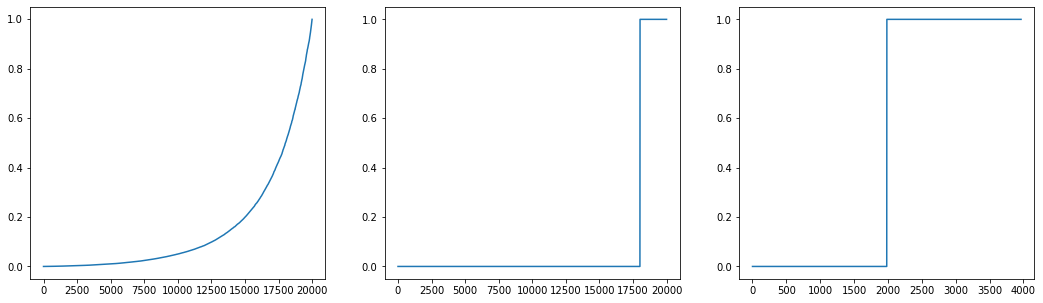

In [64]:
# Get relevant data

MAPPING = {
    'neutral': 0,
    'calm': 1,
    'happy': 2,
    'sad': 3,
    'angry': 4,
    'fearful': 5,
    'disgusted': 6,
    'surprised': 7
}

emotion = 'sad'

X = latents.numpy().reshape((-1, 512))
y = scores_rav[:, MAPPING[emotion]].numpy()
# y = scores_fer[:, MAPPING[emotion]].numpy()


# Have a look at the disribution of the scores
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.plot(np.sort(y.copy()))
y = np.round(y)

ax2.plot(np.sort(y.copy()))

# Balance classes
non_zeros = np.count_nonzero(y)
sort_inds = y.argsort()
y = y[sort_inds][max(0, len(y) - 2 * non_zeros):]
X = X[sort_inds][max(0, len(X) - 2 * non_zeros):]
print(f"Samples left: {len(X)}")

shuffle_inds = np.arange(y.shape[0])
np.random.shuffle(shuffle_inds)
y = y[shuffle_inds]
X = X[shuffle_inds]

ax3.plot(np.sort(y.copy()))
plt.show()

### Linear direction

In [93]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import accuracy_score

split = 0.9
X_train = X[:int(len(X) * split)]
y_train = y[:int(len(y) * split)]
X_test = X[int(len(X) * split):]
y_test = y[int(len(y) * split):]
clf = LogisticRegression(class_weight='balanced', max_iter=1000).fit(X_train, y_train)
# clf = svm.LinearSVC(class_weight='balanced', max_iter=10000).fit(X_train, y_train)
print(clf.coef_.shape)
print(clf.intercept_.shape)
direction = clf.coef_.reshape((1, 512))  #  + clf.intercept_

# Evaluate
y_pred = clf.predict(X_train)
print(f"Train Accuracy {accuracy_score(y_train, y_pred):.4f}")
y_pred = clf.predict(X_test)
print(f"Test Accuracy {accuracy_score(y_test, y_pred):.4f}")

(1, 512)
(1,)
Train Accuracy 0.6989
Test Accuracy 0.6795
CPU times: user 9.19 s, sys: 2.16 s, total: 11.4 s
Wall time: 1.44 s


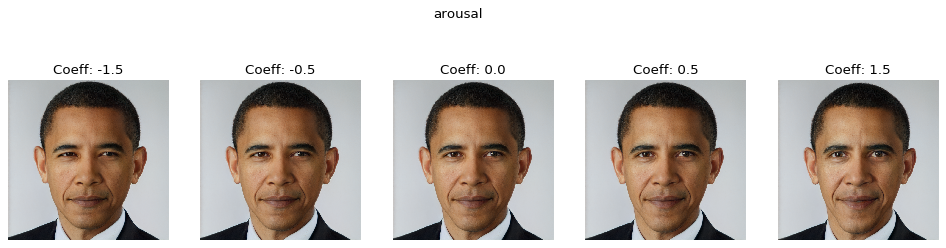

In [94]:
obama = torch.load('saves/projected_images/obama.pt').numpy()
move_and_show(g, obama, direction, [-1.5, -.5, 0, .5, 1.5], emotion)

In [95]:
# Save direction
np.save(f'saves/control_latent/directions/{emotion}_rav_lin.npy', direction * 1.5)
# np.save(f'saves/control_latent/directions/{emotion}_fer_lin.npy', direction * 1.5)

### Linear direction regression

Samples left: 3982


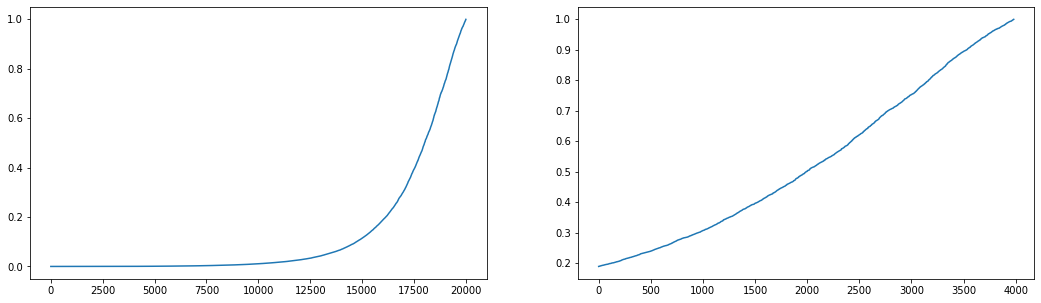

In [180]:
# Get relevant data

MAPPING = {
    'neutral': 0,
    'calm': 1,
    'happy': 2,
    'sad': 3,
    'angry': 4,
    'fearful': 5,
    'disgusted': 6,
    'surprised': 7
}

emotion = 'happy'

X = latents.numpy().reshape((-1, 512))
y = scores_rav[:, MAPPING[emotion]].numpy()
# y = scores_fer[:, MAPPING[emotion]].numpy()

# Have a look at the disribution of the scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1.plot(np.sort(y.copy()))

non_zeros = np.count_nonzero(np.round(y))
sort_inds = y.argsort()
y = y[sort_inds][max(0, len(y) - 2 * non_zeros):]
X = X[sort_inds][max(0, len(X) - 2 * non_zeros):]
print(f"Samples left: {len(X)}")

ax2.plot(y)
plt.show()

shuffle_inds = np.arange(y.shape[0])
np.random.shuffle(shuffle_inds)
y = y[shuffle_inds]
X = X[shuffle_inds]

(512,)
Train
RMSE 0.2733
Mean absolute error 0.2325


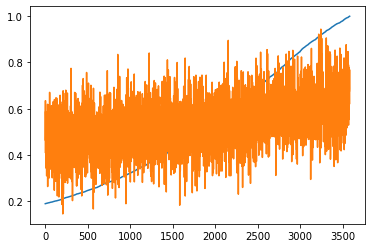

Test
RMSE 0.0000
Mean absolute error 0.2259


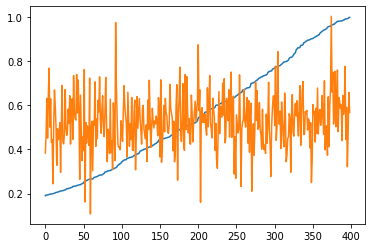

CPU times: user 805 ms, sys: 369 ms, total: 1.17 s
Wall time: 337 ms


In [181]:
%%time

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

split = 0.9
X_train = X[:int(len(X) * split)]
y_train = y[:int(len(y) * split)]
X_test = X[int(len(X) * split):]
y_test = y[int(len(y) * split):]

clf = LinearRegression().fit(X_train, y_train)
print(clf.coef_.shape)
direction = clf.coef_.reshape((1, 512))

# Evaluate
print("Train")
sort_inds = y_train.argsort()
y_pred = clf.predict(X_train[sort_inds])

print(f"RMSE {mean_squared_error(y_train, y_pred, squared=False):.4f}")
print(f"Mean absolute error {mean_absolute_error(y_train, y_pred):.4f}")

plt.plot(y_train[sort_inds])
plt.plot(y_pred)
plt.show()

print("Test")
sort_inds = y_test.argsort()
y_pred = clf.predict(X_test[sort_inds])

print(f"RMSE {mean_squared_error(y_test, y_test, squared=False):.4f}")
print(f"Mean absolute error {mean_absolute_error(y_test, y_pred):.4f}")

plt.plot(y_test[sort_inds])
plt.plot(y_pred)
plt.show()

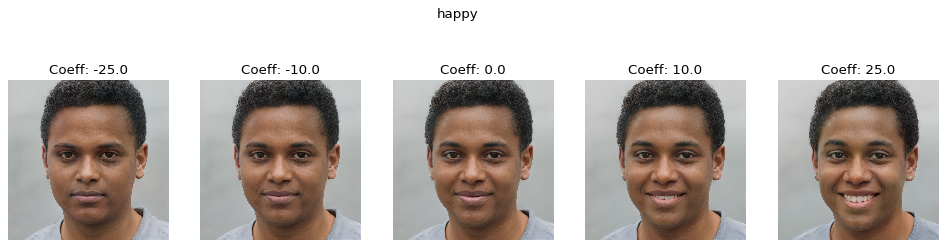

In [182]:
obama = torch.load('saves/projected_images/generated.pt').numpy()
move_and_show(g, obama, direction, [-25, -10, 0, 10, 25], emotion)

### All linear directions at once

In [5]:
X = latents.numpy().reshape((-1, 512))
y = torch.max(scores_rav, dim=1)[1].numpy()

In [7]:
%%time
clf = LogisticRegression(class_weight='balanced', max_iter=10000).fit(X, y)
print(clf.coef_.shape)
directions = clf.coef_
directions /= np.expand_dims(directions.sum(axis=1), axis=1)

(8, 512)
CPU times: user 1min 44s, sys: 46.4 s, total: 2min 30s
Wall time: 18.9 s


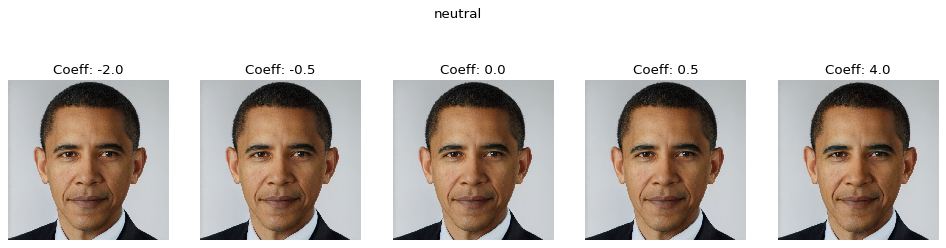

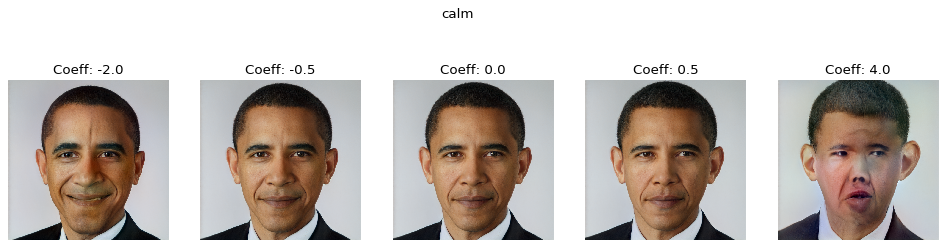

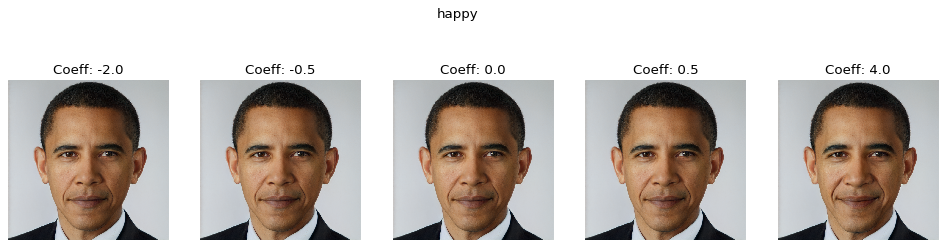

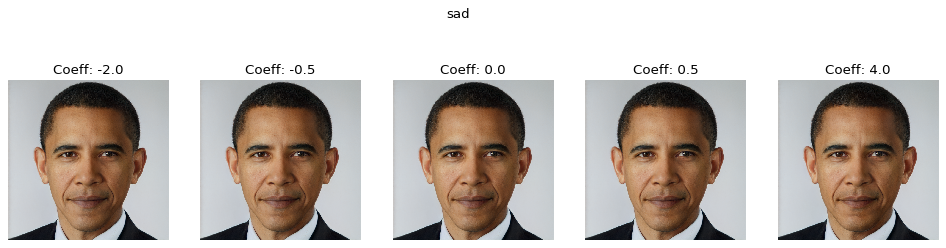

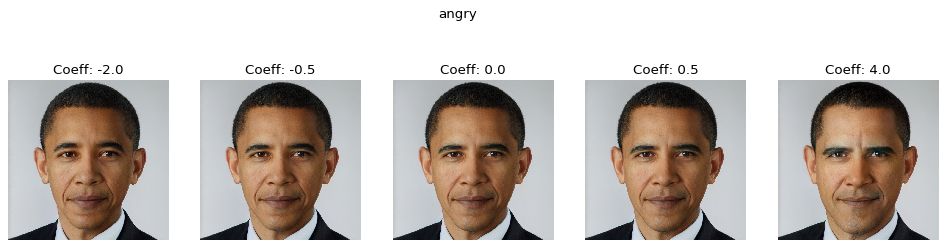

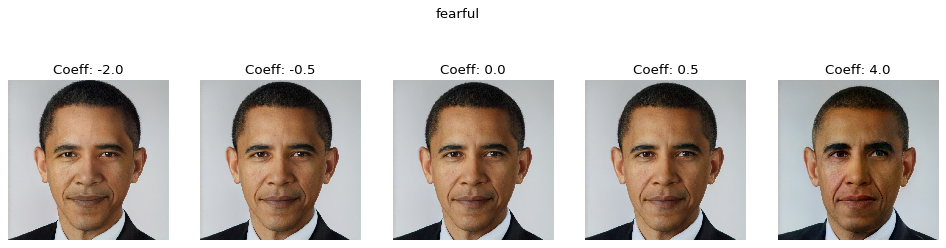

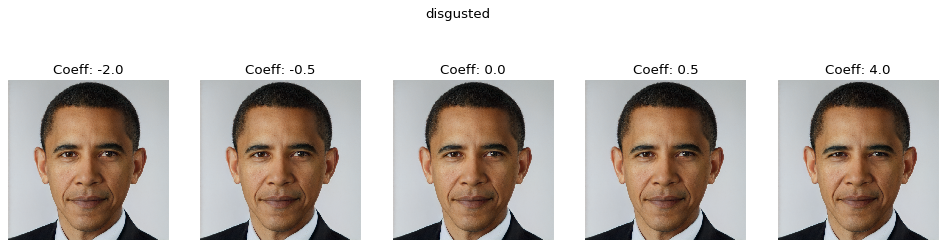

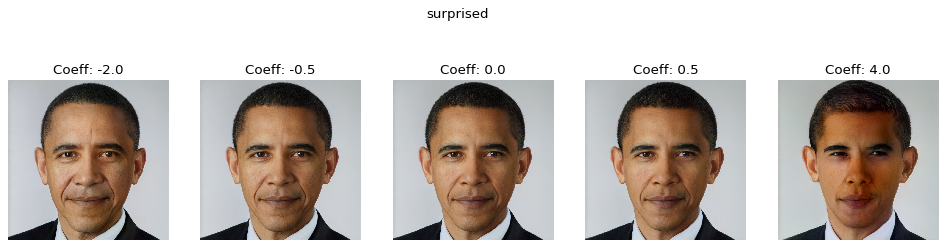

In [28]:
emotions = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgusted', 'surprised']
for d, e in zip(directions, emotions):
    obama = torch.load('saves/projected_images/obama.pt').numpy()
    move_and_show(g, obama, np.expand_dims(d, 0), [-2, -.5, 0, .5, 4.], e)

### Lightning logistic regression

In [78]:
import pytorch_lightning as pl

class PLLogisticRegression(pl.LightningModule):

    def __init__(self, X, y, split=0.9):
        super(PLLogisticRegression, self).__init__()
        
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)
        self.split = split
        
        self.l1 = torch.nn.Linear(512, 1)

    def forward(self, x):
        return self.l1(x.view(x.size(0), -1))

    def training_step(self, batch, batch_idx):
        # REQUIRED
        x, y = batch
        y_hat = self.forward(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y.view(-1, 1))
        return {'loss': loss}

    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        return torch.optim.Adam(self.parameters(), lr=0.002)

    @pl.data_loader
    def train_dataloader(self):
        # REQUIRED
        X_train = self.X[:int(len(self.X) * self.split)]
        y_train = self.y[:int(len(self.y) * self.split)]
        ds = torch.utils.data.TensorDataset(X_train, y_train)
        dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=32)
        return dl
    
    @pl.data_loader
    def test_dataloader(self):
        # REQUIRED
        X_test = self.X[int(len(self.X) * self.split):]
        y_test = self.y[int(len(self.y) * self.split):]
        ds = torch.utils.data.TensorDataset(X_test, y_test)
        dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=32)
        return dl
    

model = PLLogisticRegression(X, y)
trainer = pl.Trainer(gpus=1, logger=False, show_progress_bar=True, min_epochs=10)
trainer.fit(model)

direction = list(model.parameters())[0]  # + list(model.parameters())[1]
direction = direction.detach().cpu().numpy()
print(direction.shape)

# Evaluate
X_train = X[:int(len(X) * model.split)]
y_train = y[:int(len(y) * model.split)]
X_test = X[int(len(X) * model.split):]
y_test = y[int(len(y) * model.split):]
with torch.no_grad():
    # Train set
    y_pred = torch.sigmoid(model(torch.tensor(X_train, device=device))).cpu().numpy().reshape(-1,)
    y_pred = np.round(y_pred)
    print(f"Train Accuracy {accuracy_score(y_train, y_pred):.4f}")
    
    # Test set
    y_pred = torch.sigmoid(model(torch.tensor(X_test, device=device))).cpu().numpy().reshape(-1,)
    y_pred = np.round(y_pred)
    print(f"Test Accuracy {accuracy_score(y_test, y_pred):.4f}")

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
  Name    Type Params
0   l1  Linear  513  


Epoch 1: 100%|██████████| 563/563 [00:00<00:00, 689.78batch/s, batch_idx=562, gpu=0, loss=0.595]
(1, 512)
Train Accuracy 0.6887
Test Accuracy 0.6875


In [ ]:
obama = torch.load('saves/projected_images/obama.pt').numpy()
move_and_show(g, obama, direction, [-1.5, -.5, 0, .5, 1.5], emotion)

### Lightning linear regression

INFO:root:
  Name    Type Params
0   l1  Linear  513  


Epoch 5: 100%|██████████| 112/112 [00:00<00:00, 1012.38batch/s, batch_idx=111, loss=0.066]
(1, 512)
Train
RMSE 0.2765
Mean absolute error 0.2349


/home/meissen/miniconda3/envs/emotion-aware-facial-animation/lib/python3.7/site-packages/pytorch_lightning/callbacks/pt_callbacks.py:144: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  RuntimeWarning)


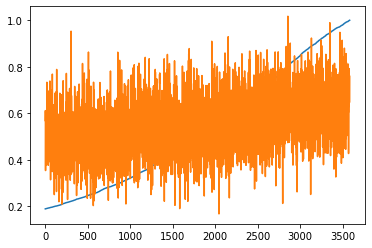

Test
RMSE 0.0000
Mean absolute error 0.2248


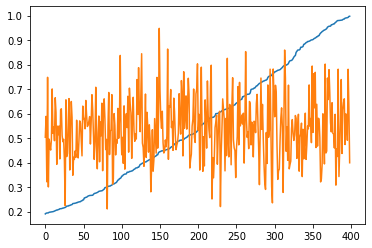

In [183]:
import pytorch_lightning as pl

class PLLinearRegression(pl.LightningModule):

    def __init__(self, X, y, split=0.9):
        super(PLLinearRegression, self).__init__()
        
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)
        self.split = split
        
        self.l1 = torch.nn.Linear(512, 1)

    def forward(self, x):
        return self.l1(x.view(x.size(0), -1))

    def training_step(self, batch, batch_idx):
        # REQUIRED
        x, y = batch
        y_hat = self.forward(x)
        loss = F.mse_loss(y_hat, y.view(-1, 1))
        return {'loss': loss}

    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        return torch.optim.Adam(self.parameters(), lr=0.002)

    @pl.data_loader
    def train_dataloader(self):
        # REQUIRED
        X_train = self.X[:int(len(self.X) * self.split)]
        y_train = self.y[:int(len(self.y) * self.split)]
        ds = torch.utils.data.TensorDataset(X_train, y_train)
        dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=32)
        return dl
    
    @pl.data_loader
    def test_dataloader(self):
        # REQUIRED
        X_test = self.X[int(len(self.X) * self.split):]
        y_test = self.y[int(len(self.y) * self.split):]
        ds = torch.utils.data.TensorDataset(X_test, y_test)
        dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=32)
        return dl
    

model = PLLinearRegression(X, y)
trainer = pl.Trainer(logger=False, show_progress_bar=True, min_epochs=5)
trainer.fit(model)

direction = list(model.parameters())[0]  # + list(model.parameters())[1]
direction = direction.detach().cpu().numpy()
print(direction.shape)

# Evaluate
X_train = X[:int(len(X) * model.split)]
y_train = y[:int(len(y) * model.split)]
X_test = X[int(len(X) * model.split):]
y_test = y[int(len(y) * model.split):]

print("Train")
sort_inds = y_train.argsort()
with torch.no_grad():
    y_pred = model(torch.tensor(X_train[sort_inds])).numpy()

print(f"RMSE {mean_squared_error(y_train, y_pred, squared=False):.4f}")
print(f"Mean absolute error {mean_absolute_error(y_train, y_pred):.4f}")

plt.plot(y_train[sort_inds])
plt.plot(y_pred)
plt.show()

print("Test")
sort_inds = y_test.argsort()
with torch.no_grad():
    y_pred = model(torch.tensor(X_train[sort_inds])).numpy()

print(f"RMSE {mean_squared_error(y_test, y_test, squared=False):.4f}")
print(f"Mean absolute error {mean_absolute_error(y_test, y_pred):.4f}")

plt.plot(y_test[sort_inds])
plt.plot(y_pred)
plt.show()

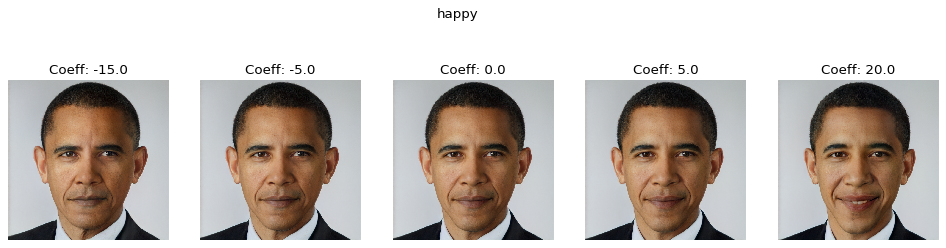

In [184]:
obama = torch.load('saves/projected_images/obama.pt').numpy()
move_and_show(g, obama, direction, [-15, -5, 0, 5, 20], emotion)

### Non-linear model with inverse neural network

In [80]:
import pytorch_lightning as pl

import FrEIA.framework as Ff
import FrEIA.modules as Fm


class InvModel(nn.Module):
    def __init__(self, model):
        super(InvModel, self).__init__()
        
        self.inn = model.inn
        self.linear = model.linear
        
    def forward(self, x):
        x = self.inn(x)
        x = self.linear(x)
        return x
    
    def inverse(self, coeff):
        direction = self.linear.weight * coeff
        direction = self.inn(direction, rev=True).detach().cpu().numpy()
        return direction


class PLNonLinClassification(pl.LightningModule):

    def __init__(self, X, y, split=0.9):
        super(PLNonLinClassification, self).__init__()
        
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)
        self.split = split
        
        def subnet_fc(c_in, c_out):
            return nn.Sequential(
                nn.Linear(c_in, c_out),
                nn.BatchNorm1d(c_out),
                nn.ReLU(),
                # nn.Linear(512, c_out),
                # nn.BatchNorm1d(512),
                # nn.ReLU()
            )
        
        nodes = [Ff.InputNode(512, name='input')]

        nodes.append(Ff.Node(nodes[-1],
                             Fm.GLOWCouplingBlock,
                             {'subnet_constructor': subnet_fc, 'clamp': 2.0},
                             name='coupling_1'))

        nodes.append(Ff.OutputNode(nodes[-1], name='output'))
        self.inn = Ff.ReversibleGraphNet(nodes, verbose=False)
        
        self.linear = nn.Linear(512, 1)

    def forward(self, x):
        x = self.inn(x)
        x = self.linear(x)
        return x
    
    def inverse(self, coeff):
        direction = self.linear.weight * coeff
        direction = self.inn(direction, rev=True).detach().cpu().numpy()
        return direction

    def training_step(self, batch, batch_idx):
        # REQUIRED
        x, y = batch
        y_hat = self.forward(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y.view(-1, 1))
        return {'loss': loss}
    
    """
    def validation_step(self, batch, batch_idx):
        # REQUIRED
        x, y = batch
        y_hat = self.forward(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y.view(-1, 1))
        return {'loss': loss}
    
    def validation_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        return {'val_loss': avg_loss}
    """

    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        return torch.optim.Adam(self.parameters(), lr=0.02)

    @pl.data_loader
    def train_dataloader(self):
        # REQUIRED
        X_train = self.X[:int(len(self.X) * self.split)]
        y_train = self.y[:int(len(self.y) * self.split)]
        ds = torch.utils.data.TensorDataset(X_train, y_train)
        dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=32)
        return dl
    
    @pl.data_loader
    def val_dataloader(self):
        # REQUIRED
        X_test = self.X[int(len(self.X) * self.split):]
        y_test = self.y[int(len(self.y) * self.split):]
        ds = torch.utils.data.TensorDataset(X_test, y_test)
        dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=32)
        return dl
    

model = PLNonLinClassification(X, y)
trainer = pl.Trainer(gpus=1, logger=False, show_progress_bar=True, min_epochs=1)
trainer.fit(model)
inn = InvModel(model)

# Evaluate
X_train = X[:int(len(X) * model.split)]
y_train = y[:int(len(y) * model.split)]
X_test = X[int(len(X) * model.split):]
y_test = y[int(len(y) * model.split):]
with torch.no_grad():
    # Train set
    y_pred = torch.sigmoid(model(torch.tensor(X_train, device=device))).cpu().numpy().reshape(-1,)
    y_pred = np.round(y_pred)
    print(f"Train Accuracy {accuracy_score(y_train, y_pred):.4f}")
    
    # Test set
    y_pred = torch.sigmoid(model(torch.tensor(X_test, device=device))).cpu().numpy().reshape(-1,)
    y_pred = np.round(y_pred)
    print(f"Test Accuracy {accuracy_score(y_test, y_pred):.4f}")

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                      Name                Type Params
0                      inn  ReversibleGraphNet  265 K
1          inn.module_list          ModuleList  265 K
2        inn.module_list.1   GLOWCouplingBlock  265 K
3     inn.module_list.1.s1          Sequential  132 K
4   inn.module_list.1.s1.0              Linear  131 K
5   inn.module_list.1.s1.1         BatchNorm1d    1 K
6   inn.module_list.1.s1.2                ReLU    0  
7     inn.module_list.1.s2          Sequential  132 K
8   inn.module_list.1.s2.0              Linear  131 K
9   inn.module_list.1.s2.1         BatchNorm1d    1 K
10  inn.module_list.1.s2.2                ReLU    0  
11       inn.module_list.2               dummy    0  
12                  linear              Linear  513  


Epoch 1: 100%|██████████| 563/563 [00:01<00:00, 293.46batch/s, batch_idx=562, gpu=0, loss=0.674]
Train Accuracy 0.6815
Test Accuracy 0.6685


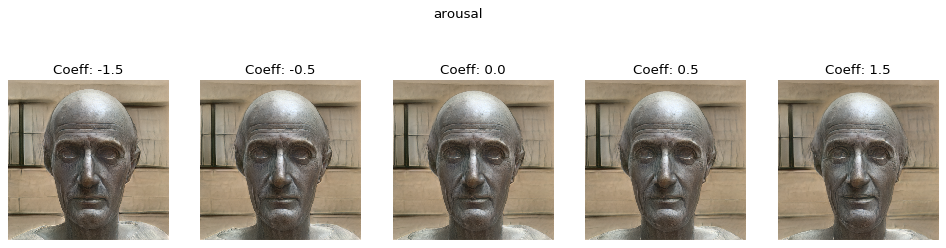

In [83]:
obama = torch.load('saves/projected_images/TUM_guy.pt').numpy()
move_and_show_non_lin(g, inn, obama, [-1.5, -.5, 0, .5, 1.5], emotion)

### Non linear regression

In [1]:
import pytorch_lightning as pl

import FrEIA.framework as Ff
import FrEIA.modules as Fm


class InvModel(nn.Module):
    def __init__(self, model):
        super(InvModel, self).__init__()
        
        self.inn = model.inn
        self.linear = model.linear
        
    def forward(self, x):
        x = self.inn(x)
        x = self.linear(x)
        return x
    
    def inverse(self, coeff):
        direction = self.linear.weight * coeff
        direction = self.inn(direction, rev=True).detach().cpu().numpy()
        return direction


class PLNonLinRegression(pl.LightningModule):

    def __init__(self, X, y, split=0.9):
        super(PLNonLinRegression, self).__init__()
        
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)
        self.split = split
        
        def subnet_fc(c_in, c_out):
            return nn.Sequential(
                nn.Linear(c_in, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Linear(512, c_out),
                nn.ReLU()
            )
        
        nodes = [Ff.InputNode(512, name='input')]

        nodes.append(Ff.Node(nodes[-1],
                             Fm.GLOWCouplingBlock,
                             {'subnet_constructor': subnet_fc, 'clamp': 2.0},
                             name='coupling_1'))

        nodes.append(Ff.OutputNode(nodes[-1], name='output'))
        self.inn = Ff.ReversibleGraphNet(nodes, verbose=False)
        
        self.linear = nn.Linear(512, 1)

    def forward(self, x):
        x = self.inn(x)
        x = self.linear(x)
        return x
    
    def inverse(self, coeff):
        direction = self.linear.weight * coeff
        direction = self.inn(direction, rev=True).detach().cpu().numpy()
        return direction

    def training_step(self, batch, batch_idx):
        # REQUIRED
        x, y = batch
        y_hat = self.forward(x)
        loss = F.mse_loss(y_hat, y.view(-1, 1))
        return {'loss': loss}

    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        return torch.optim.Adam(self.parameters(), lr=0.02)

    @pl.data_loader
    def train_dataloader(self):
        # REQUIRED
        X_train = self.X[:int(len(self.X) * self.split)]
        y_train = self.y[:int(len(self.y) * self.split)]
        ds = torch.utils.data.TensorDataset(X_train, y_train)
        dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=32)
        return dl
    
    @pl.data_loader
    def test_dataloader(self):
        # REQUIRED
        X_test = self.X[int(len(self.X) * self.split):]
        y_test = self.y[int(len(self.y) * self.split):]
        ds = torch.utils.data.TensorDataset(X_test, y_test)
        dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=32)
        return dl
    

model = PLNonLinRegression(X, y)
trainer = pl.Trainer(logger=False, show_progress_bar=True, min_epochs=20)
trainer.fit(model)
inn = InvModel(model)

# Evaluate
X_train = X[:int(len(X) * model.split)]
y_train = y[:int(len(y) * model.split)]
X_test = X[int(len(X) * model.split):]
y_test = y[int(len(y) * model.split):]

print("Train")
sort_inds = y_train.argsort()
with torch.no_grad():
    y_pred = model(torch.tensor(X_train[sort_inds])).numpy()

print(f"RMSE {mean_squared_error(y_train, y_pred, squared=False):.4f}")
print(f"Mean absolute error {mean_absolute_error(y_train, y_pred):.4f}")

plt.plot(y_train[sort_inds])
plt.plot(y_pred)
plt.show()

print("Test")
sort_inds = y_test.argsort()
with torch.no_grad():
    y_pred = model(torch.tensor(X_test[sort_inds])).numpy()

print(f"RMSE {mean_squared_error(y_test, y_pred, squared=False):.4f}")
print(f"Mean absolute error {mean_absolute_error(y_test, y_pred):.4f}")

plt.plot(y_test[sort_inds])
plt.plot(y_pred)
plt.show()

NameError: name 'nn' is not defined

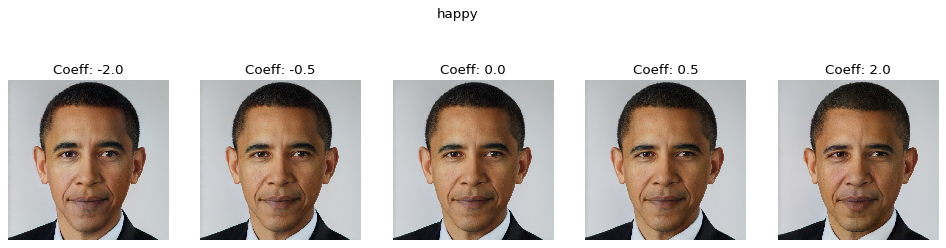

In [190]:
obama = torch.load('saves/projected_images/obama.pt').numpy()
move_and_show_non_lin(g, inn, obama, [-2, -.5, 0, .5, 2], emotion)